# Synthetic worm image generator

This notebook should result in the creation of a set of realistic but synthetic images (and ground-truth masks) of c. elegans worms.

### Imports

In [1]:
import numpy as np
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
from copy import copy

## Pseudocode

load image

choose a mask

worm = pixels corresponding to this mask from originial image

apply transform to worm

apply transform to mask

insert transformed worm into original image

save image
save mask

# Functions


In [2]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 4)).astype(np.uint8)[:,:,:3]

In [3]:
def synthesise_worms(image_np, masks, trans_scale=30, rot_scale=45):
    new_image = copy(image_np)

    for m in range(int(len(masks)/2)):

        shifts = [int(np.random.normal(scale=trans_scale)),int(np.random.normal(scale=trans_scale)),0]
        angle = np.random.normal(rot_scale)

        worm_mask = masks[m]
        worm_where = np.where(worm_mask)

        #Hack to catch cases where the provided mask is empty
        if not worm_where[0].size:
            continue

        worm_center = tuple((int(np.mean(worm_where[1])), int(np.mean(worm_where[0]))))
        rot_mat = cv2.getRotationMatrix2D(worm_center, angle, 1.0)
        rotated_image = cv2.warpAffine(src=image_np, M=rot_mat, dsize=image_np.shape[:2], flags=cv2.INTER_LINEAR)
        rotated_mask = cv2.warpAffine(worm_mask, rot_mat, worm_mask.shape[:2], flags=cv2.INTER_LINEAR)
        rotated_where = np.where(rotated_mask)

        # new_image[rotated_where] = rotated_image[rotated_where]


        # worm_where_shifted = np.where(worm_mask)
        worm_where_shifted = np.where(rotated_mask)

        for i,j in zip(worm_where_shifted,shifts):
            if np.max(i+j) >= image_np.shape[0] or np.min(i+j) < 0:
                pass
            else:
                i += j

        new_image[worm_where_shifted] = rotated_image[rotated_where]
        new_mask = np.zeros(masks[m].shape,dtype=np.uint8)
        new_mask[worm_where_shifted] = 255
        masks.append(new_mask)
    
    return new_image, masks


In [4]:
def poisson_synthesise_worms(image_np, masks, trans_scale=30, rot_scale=45):
    new_image = copy(image_np)
    cv2_blended_image = copy(image_np)
#     cv2_normal_cloned_image = copy(image_np)

    for m in range(int(2*len(masks)/3)):

        shifts = [int(np.random.normal(scale=trans_scale)),int(np.random.normal(scale=trans_scale)),0]
        angle = np.random.normal(rot_scale)

        worm_mask = masks[m]
        worm_where = np.where(worm_mask)
        

        #Hack to catch cases where the provided mask is empty
        if not worm_where[0].size:
            continue

        worm_center = tuple((int(np.mean(worm_where[1])), int(np.mean(worm_where[0]))))
        rot_mat = cv2.getRotationMatrix2D(worm_center, angle, 1.0)
        rotated_image = cv2.warpAffine(src=image_np, M=rot_mat, dsize=image_np.shape[:2], flags=cv2.INTER_LINEAR)
        rotated_mask = cv2.warpAffine(worm_mask, rot_mat, worm_mask.shape[:2], flags=cv2.INTER_LINEAR)
        rotated_where = np.where(rotated_mask)

#         new_image[rotated_where] = rotated_image[rotated_where]


        # worm_where_shifted = np.where(worm_mask)
        worm_where_shifted = np.where(rotated_mask)

        for i,j in zip(worm_where_shifted,shifts):
            if np.max(i+j) >= image_np.shape[0] or np.min(i+j) < 0:
                pass
            else:
                i += j
        
        shifted_center = tuple((int(np.mean(worm_where_shifted[1])), int(np.mean(worm_where_shifted[0]))))
        
        if np.min(shifted_center[0]) < 25 or np.min(shifted_center[1]) < 25:
            continue
        
        if np.max(shifted_center[0]) > image_np.shape[0] - 25 or np.max(shifted_center[1]) > image_np.shape[0] - 25:
            continue
        
        #corners of rotated bbox
        #if space within image dimensions, expand the bbox by 10px all round to improve blending
        x_l = np.min(rotated_where[1])
        if x_l - 10 >= 0:
            x_l -= 10
        
        x_r = np.max(rotated_where[1])
        if x_r + 10 < image_np.shape[1]:
            x_r += 10
            
        
        y_t = np.min(rotated_where[0])
        if y_t - 10 >= 0:
            y_t -= 10
            
        y_b = np.max(rotated_where[0])
        if y_b + 10 < image_np.shape[0]:
            y_b += 10
        
        
        cv2_mask = np.zeros(masks[m].shape,dtype=np.uint8)
        cv2_mask[y_t:y_b, x_l:x_r,:] = 255
        
        new_image[worm_where_shifted] = rotated_image[rotated_where]
        new_mask = np.zeros(masks[m].shape,dtype=np.uint8)
        new_mask[worm_where_shifted] = 255
        masks.append(new_mask)
                
#         cv2_normal_cloned_image = cv2.seamlessClone(rotated_image, cv2_normal_cloned_image, new_mask, shifted_center, cv2.NORMAL_CLONE)
        cv2_blended_image = cv2.seamlessClone(rotated_image, cv2_blended_image, cv2_mask, shifted_center, cv2.MIXED_CLONE)
        
    return new_image, masks, cv2_blended_image




In [5]:
def plot_old_and_new(image_np, new_image, plot_masks=False, masks=None):
    w = 2
    if plot_masks:
        w = 3
    
    plt.figure(figsize=IMAGE_SIZE)

    plt.subplot(1,w,1)
    plt.imshow(image_np)

    plt.subplot(1,w,2)
    plt.imshow(new_image)

    if plot_masks:
        masks_array = np.asarray(masks)
        mask_sum = np.sum(masks_array, axis=3)
        mask_sum = np.sum(mask_sum, axis=0)
        plt.subplot(1,w,3)
        plt.imshow(mask_sum)
        
    plt.show()
    plt.close()

In [6]:
def plot_synthetic_images(img_list, plot_masks=False, masks=None, names=None):
    N = len(img_list)
    if plot_masks:
        N+=1
    
    plt.figure(figsize=IMAGE_SIZE)
    
    for n in range(len(img_list)):
        plt.subplot(1,N,n+1)
        if names:
            plt.gca().set_title(names[n])
        plt.imshow(img_list[n])
        
    if plot_masks:
        masks_array = np.asarray(masks)
        mask_sum = np.sum(masks_array, axis=3)
        mask_sum = np.sum(mask_sum, axis=0)
        plt.subplot(1,N,N)
        if names:
            plt.gca().set_title('All masks')
        plt.imshow(mask_sum)
    
    plt.show()
    plt.close()

In [7]:
def save_synth_data(syn_image, syn_masks, fname):
    OUTPUT_IMAGE_DIR = os.path.join(PATH_TO_OUTPUTS_DIR, '{}/image'.format(fname))
    os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
    
    OUTPUT_IMAGE_PATH = os.path.join(OUTPUT_IMAGE_DIR, 'image_{}.png'.format(fname))
    
    output_image = Image.fromarray(syn_image)
    output_image.save(OUTPUT_IMAGE_PATH)
    
    
    OUTPUT_MASKS_DIR = os.path.join(PATH_TO_OUTPUTS_DIR, '{}/masks'.format(fname))
    os.makedirs(OUTPUT_MASKS_DIR, exist_ok=True)
    
    for m in range(len(syn_masks)):
        OUTPUT_MASK_PATH = os.path.join(OUTPUT_MASKS_DIR, 'mask_{}.png'.format(m))
        output_mask = Image.fromarray(syn_masks[m])
        output_mask.save(OUTPUT_MASK_PATH)

# Main body


## Define data, paths, etc

In [8]:
NUM_IMAGES = 5

# Size, in inches, of the output images.
IMAGE_SIZE = (50,50)


PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/Data_pre_exams/full_images/'

PATH_TO_OUTPUTS_DIR = '/Users/daniel/Documents/UCL/Project/Data/synthesised_poisson_data/'

FNAMES = [f for f in os.listdir(PATH_TO_TEST_IMAGES_DIR) if not f.startswith('.')]
FNAMES = sorted(FNAMES, key=int)[:NUM_IMAGES]



## Perform data synthesis

In [9]:
save_images = False

0


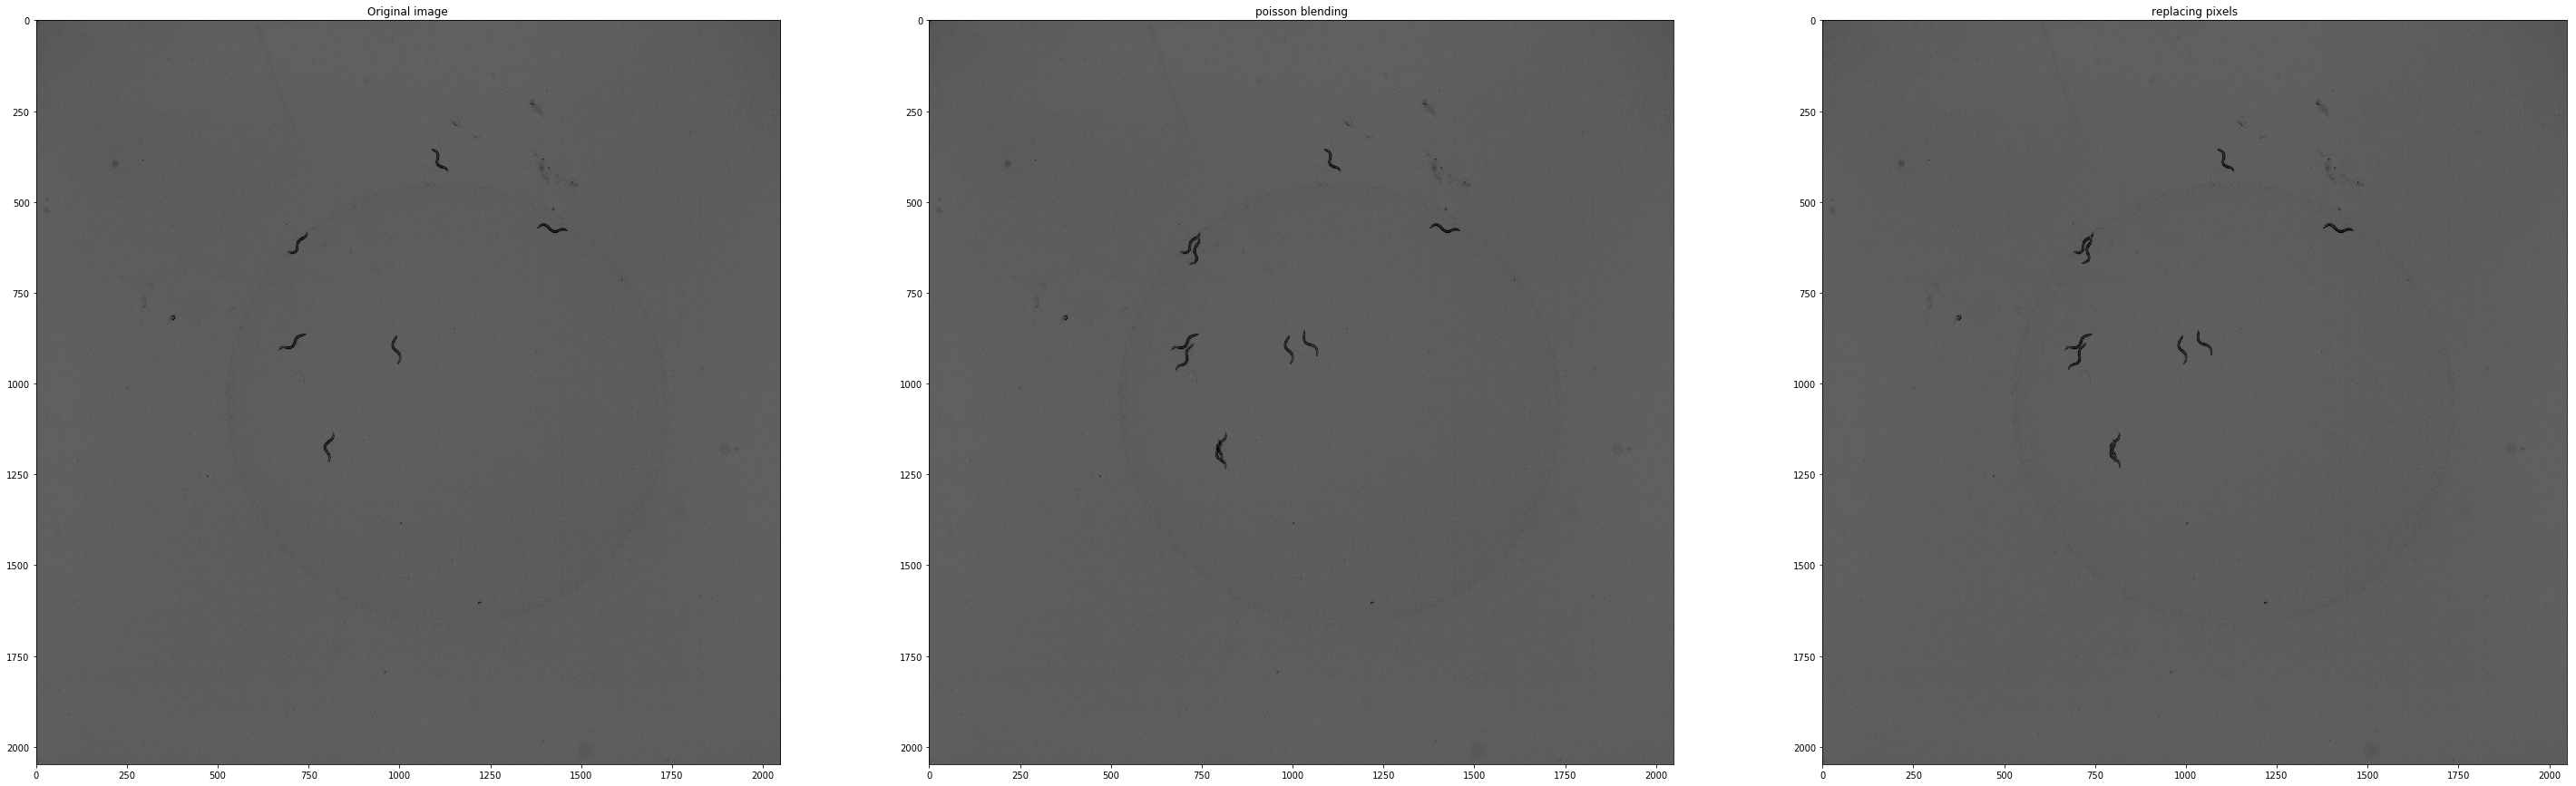

1


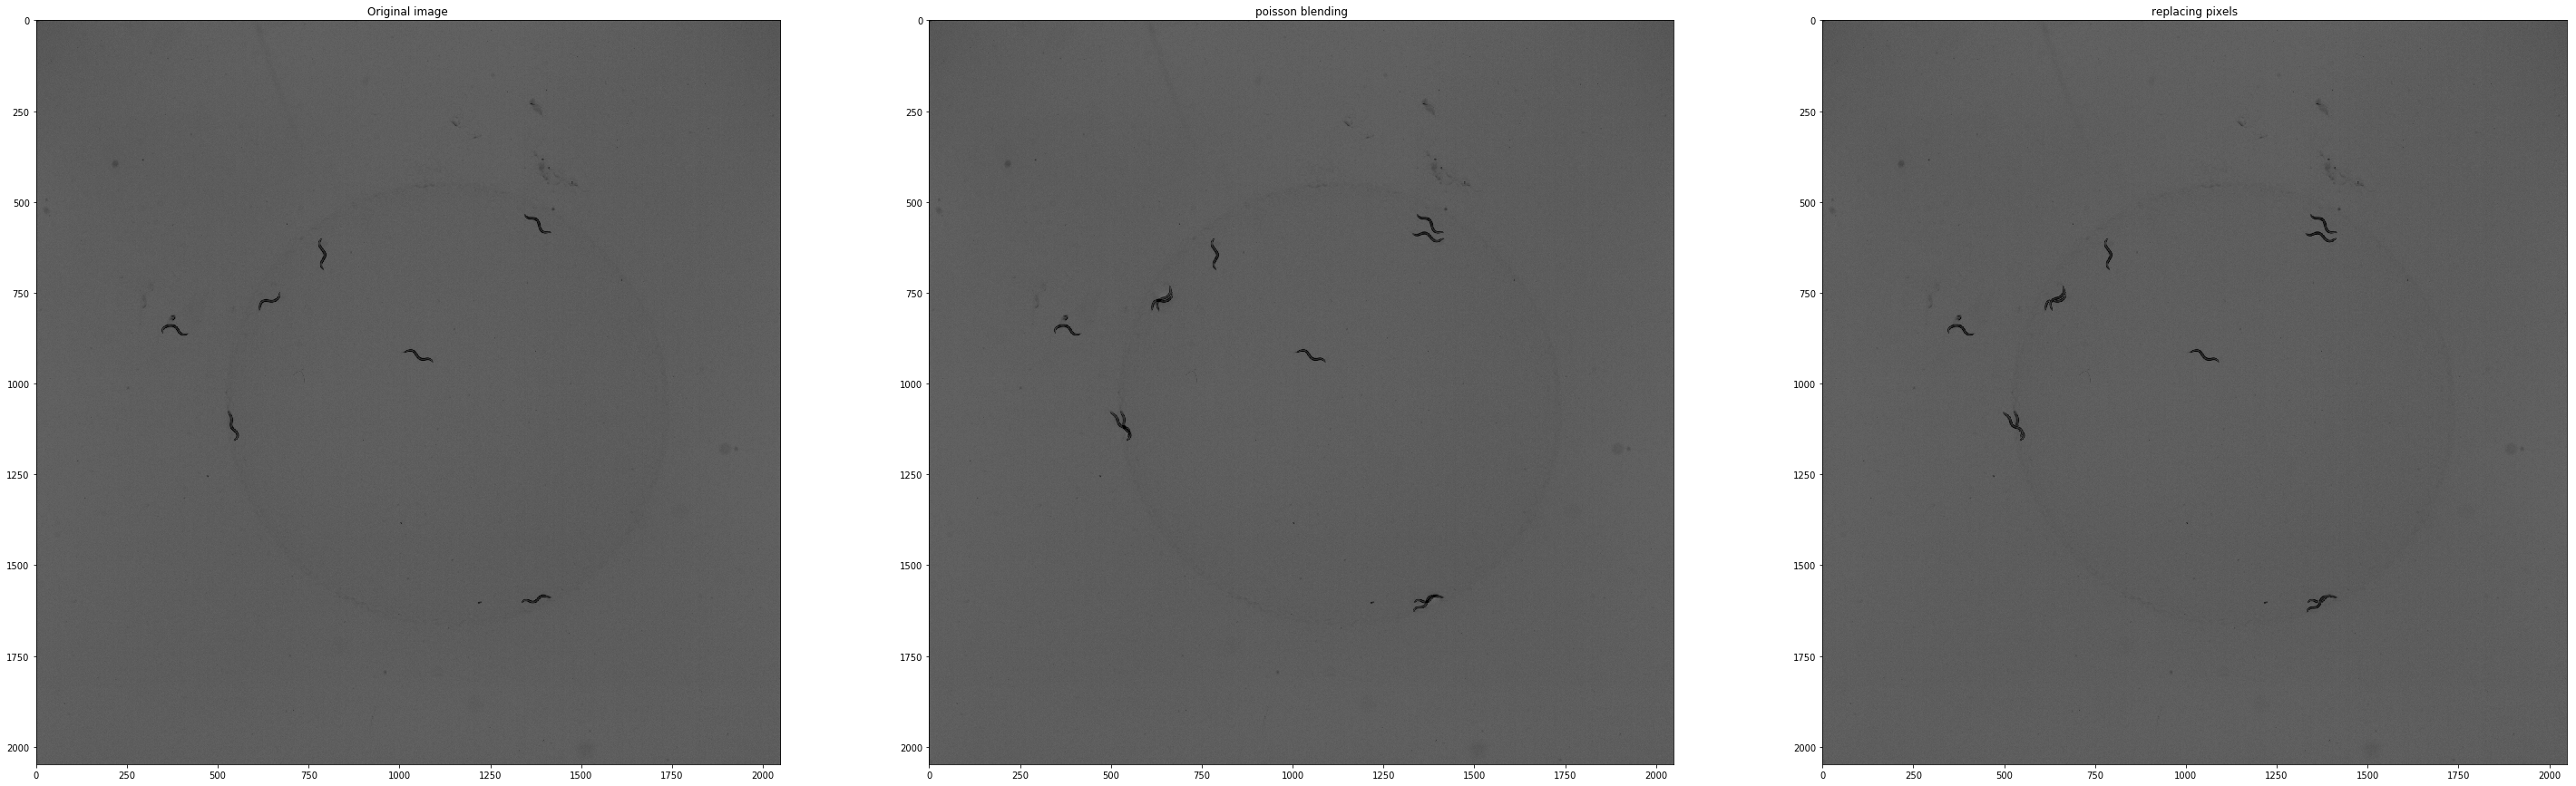

2


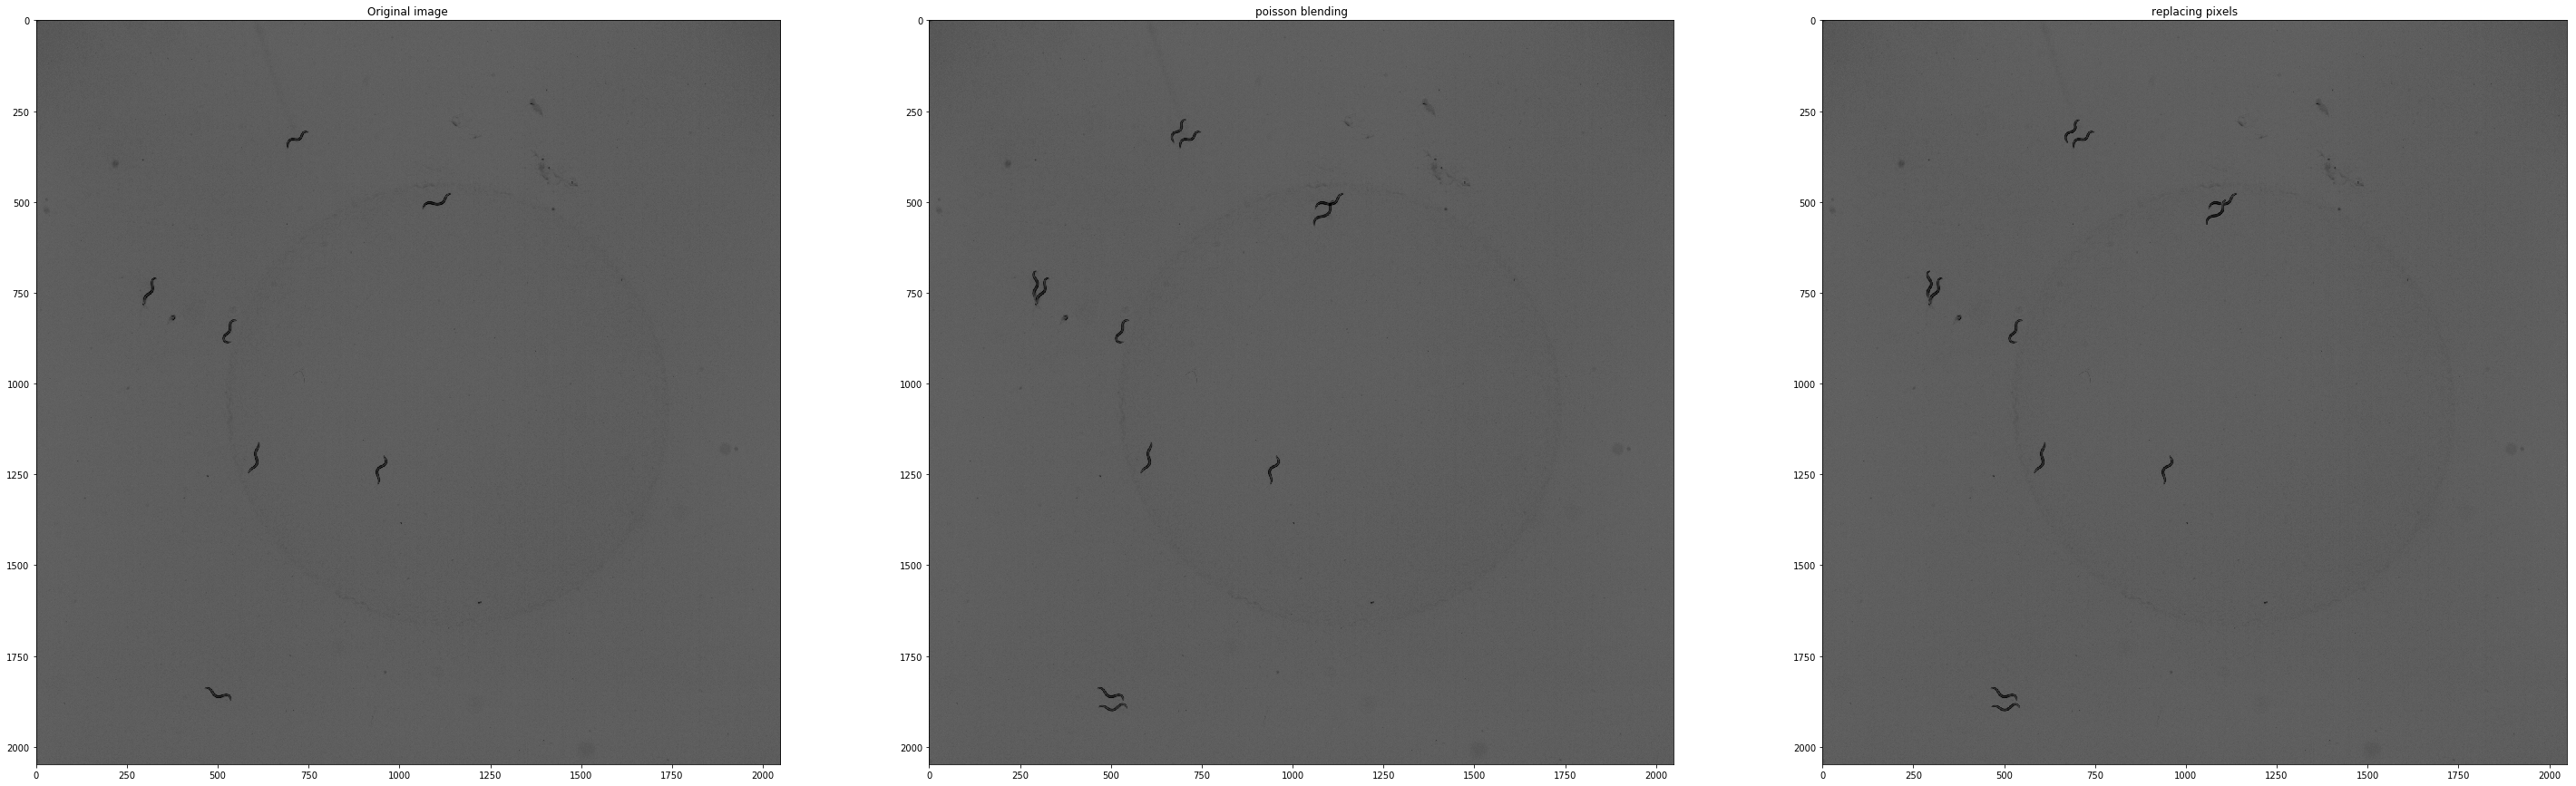

3


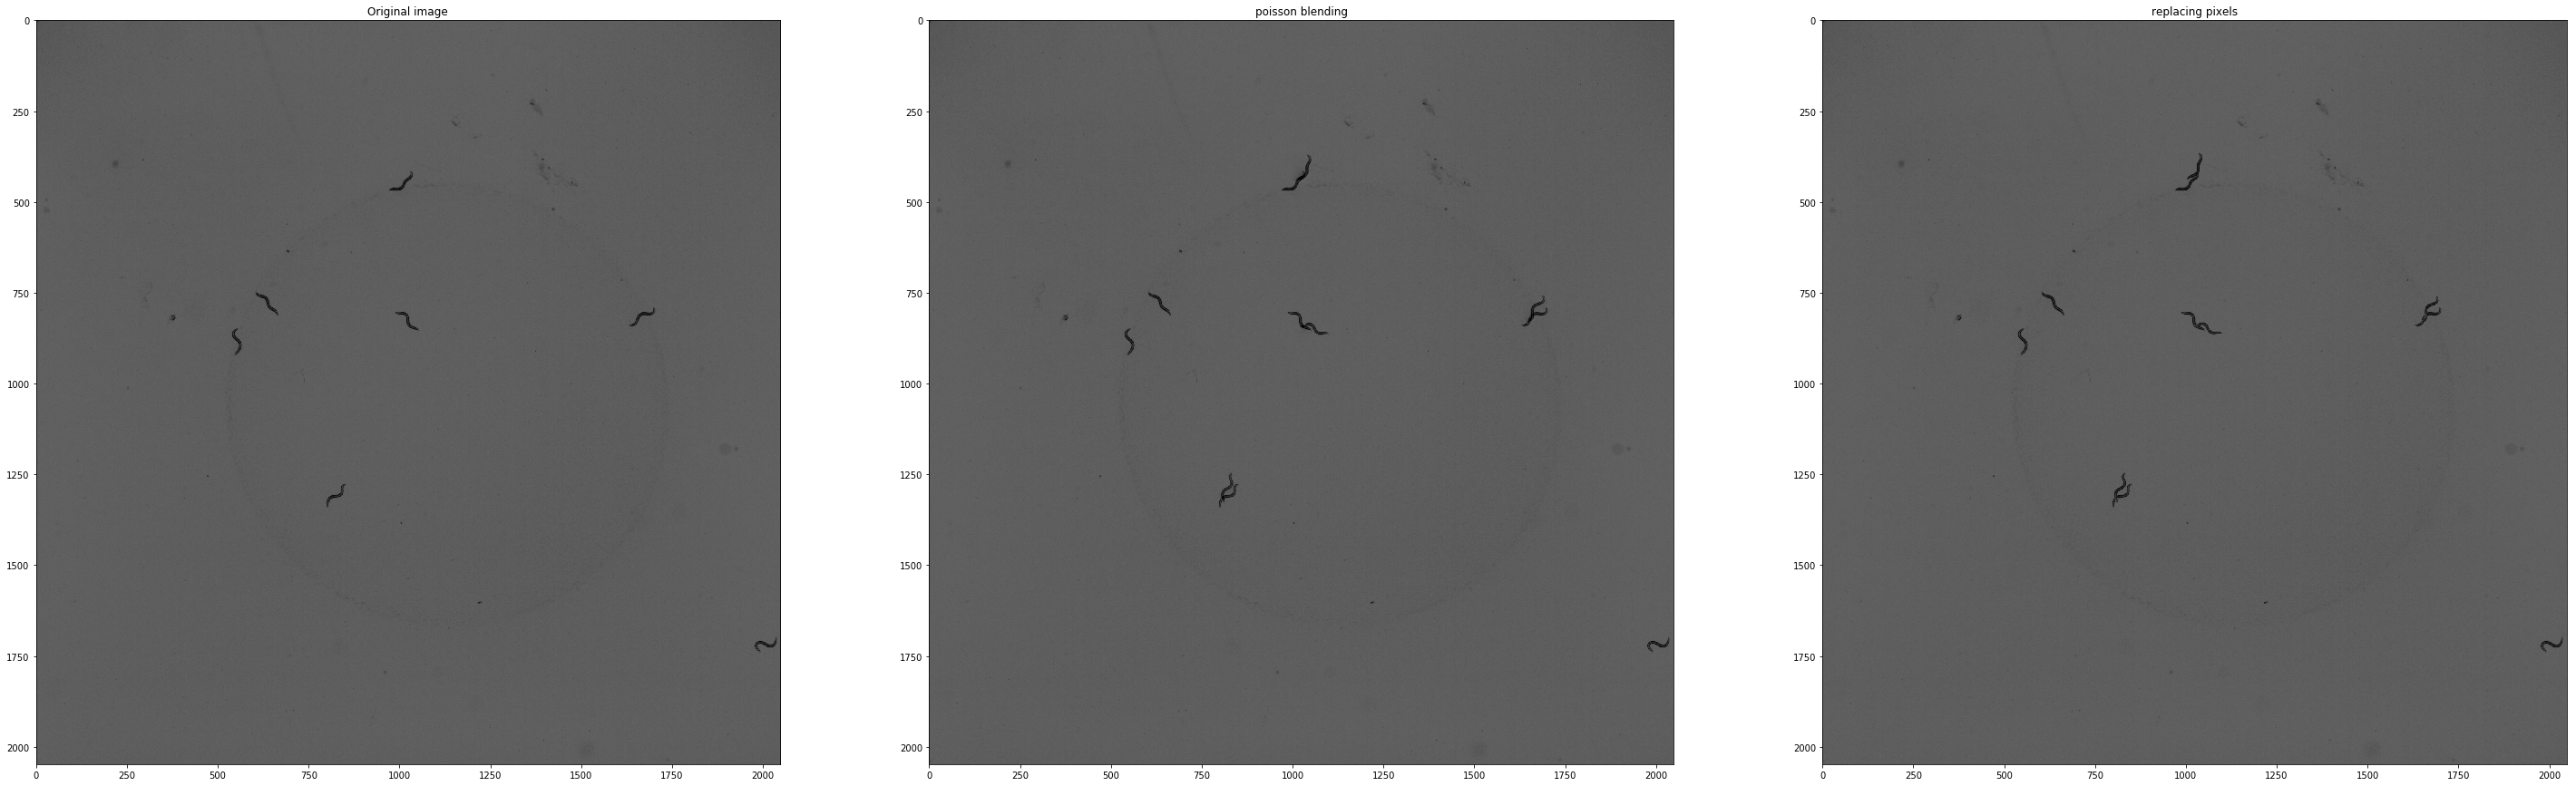

4


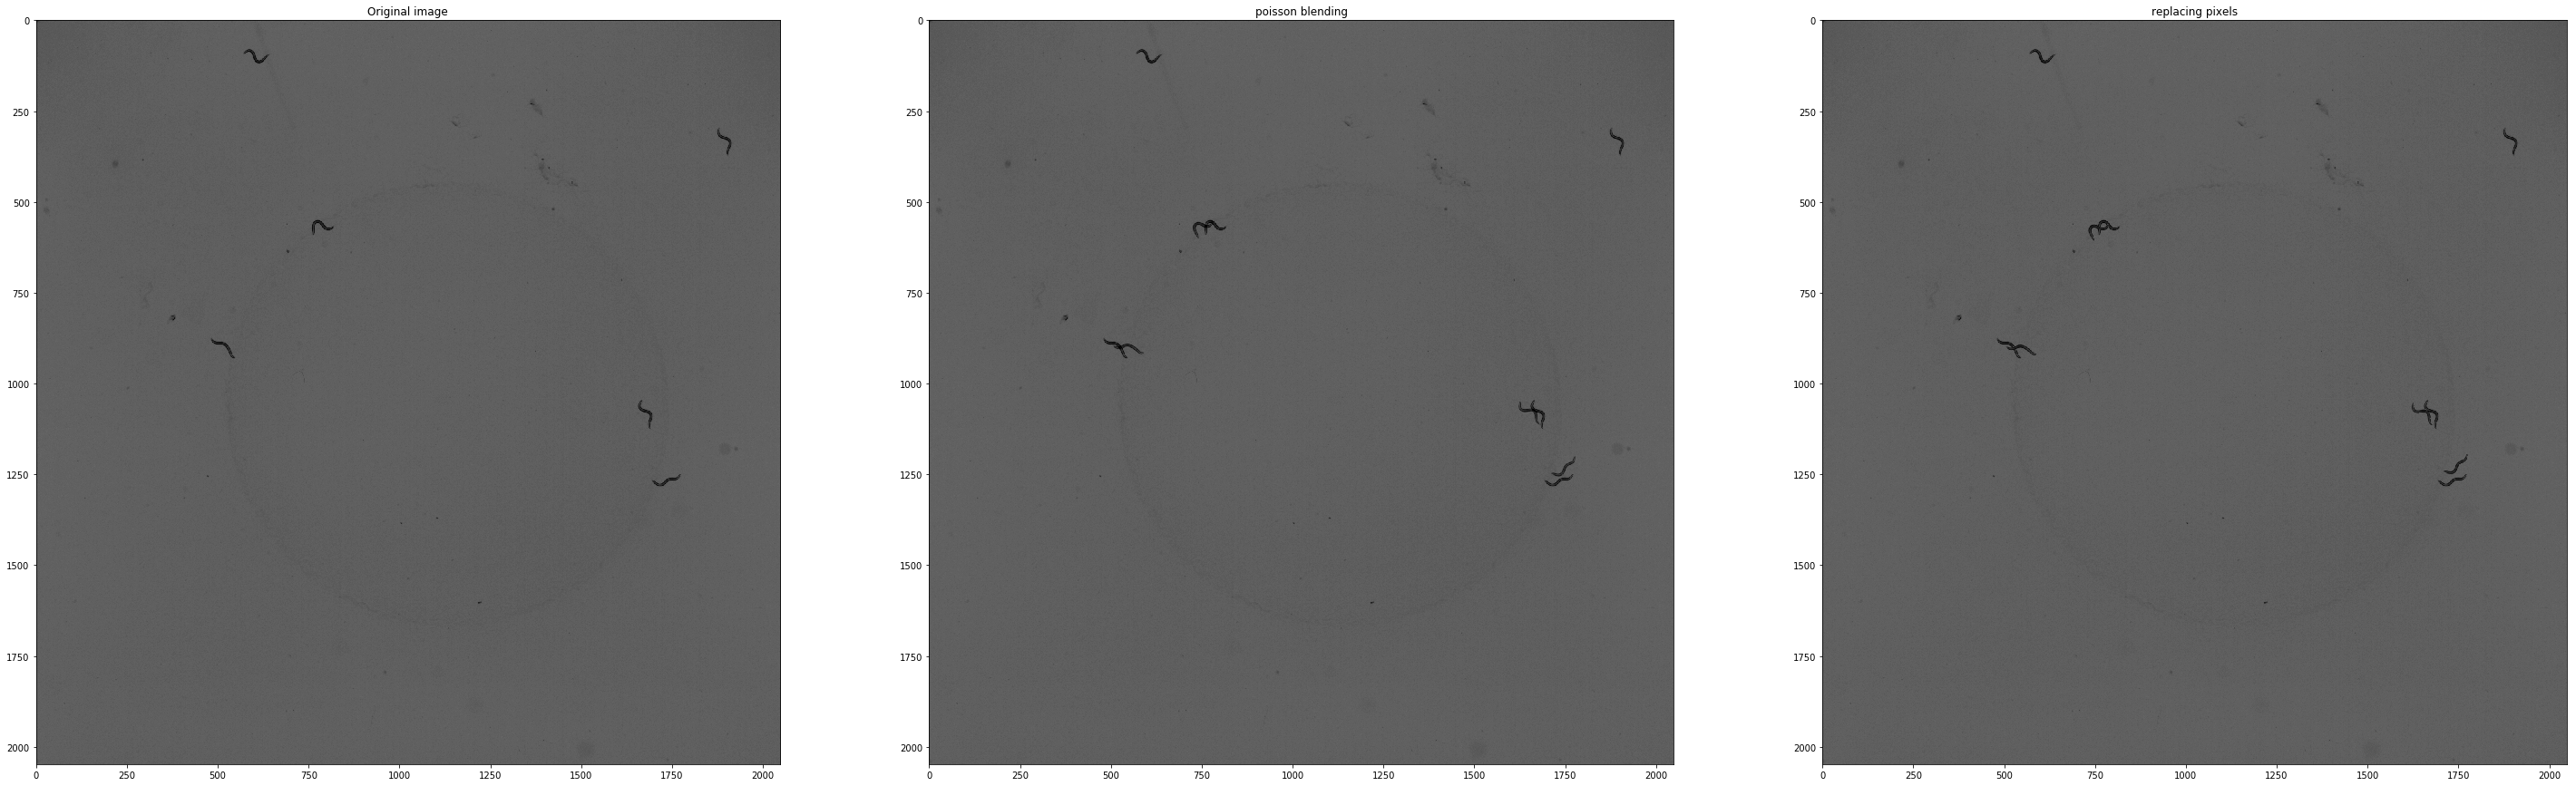

In [11]:
for fname in FNAMES:
    print(fname)
    TEST_IMAGE_PATH = os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/image/image_{}.png'.format(fname,fname))
    image = Image.open(TEST_IMAGE_PATH)
    image_np = load_image_into_numpy_array(image)

    MASKS_DIR = os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/masks/'.format(fname))
    MASK_FNAMES = sorted([f for f in os.listdir(MASKS_DIR) if not f.startswith('.')])

    masks = []
    for m in MASK_FNAMES:
        mask = Image.open(os.path.join(MASKS_DIR,m))
        masks.append(np.asarray(mask)[:,:,:3])
    
    syn_image, syn_masks, poisson_clone = poisson_synthesise_worms(image_np, masks, trans_scale=20, rot_scale=25)
    
    
    
    names = ['Original image', 'poisson blending', 'replacing pixels']
    plot_synthetic_images([image_np, poisson_clone, syn_image], names=names)
    
    if save_images:
        save_synth_data(poisson_clone, syn_masks, fname)
        